In [1]:
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

### plot offline experiments

In [11]:
ys = []
log_folder = "alphad3m_log/"
combination_names = ['DDN+OneHot', 'DDN+GIN', 'DDN+BO', 'MF+OneHot', 'MF+GIN']

for combination_name in combination_names:
    print("="*30)
    print(combination_name)
    log_target_test_pred_time = log_folder+combination_name+'_target_test_pred_time_03102022'
    target_test_pred_time = pickle.load(open(log_target_test_pred_time, "rb"))
    performance_sum = defaultdict(float)
    performance_count = defaultdict(int)
    for key in target_test_pred_time:
        if target_test_pred_time[key] != 'N.A.':
            DDN_threshold = key.split('_')[-1]
            mae = target_test_pred_time[key][-2]
            performance_sum[DDN_threshold] += mae
            performance_count[DDN_threshold] += 1
    y = []
    for DDN_threshold in performance_sum:
        avg = performance_sum[DDN_threshold]/performance_count[DDN_threshold]
#         print(DDN_threshold, avg)
        y.append(avg)
    ys.append(y)
    
 

DDN+OneHot
DDN+GIN
DDN+BO
MF+OneHot
MF+GIN


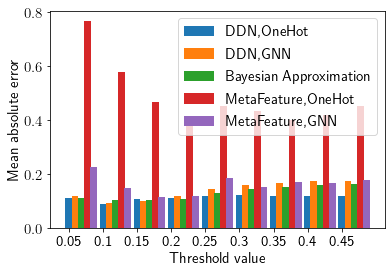

In [13]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = '15'
label_names = ['DDN,OneHot', 'DDN,GNN', 'Bayesian Approximation', 'MetaFeature,OneHot', 'MetaFeature,GNN']

x = np.arange(9)
for i,y in enumerate(ys):
    plt.bar(x+i*0.18, y, label=label_names[i], width=0.2)

plt.xticks(x, [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45])
plt.xlabel("Threshold value")
plt.ylabel("Mean absolute error")
# plt.axhline(y=min(ys[0])+0.0025, color='r', linestyle='--')
# plt.legend(loc='center left', bbox_to_anchor=(0.2, 1.0))
plt.legend()

plt.savefig("figs_0310/encoding_combination_alphad3m.pdf", bbox_inches="tight")
plt.show()

### speedup boxplot

In [14]:
AutoML_path = ""
log_folder = "alphad3m_log"

log_DDN = AutoML_path+log_folder+'/DDN_single_time'
log_pipeline_steps = AutoML_path+log_folder+'/pipeline_steps_class_withTime'

DDN = pickle.load(open(log_DDN, "rb"))
print(len(DDN))

pipeline_steps_class = pickle.load(open(log_pipeline_steps, 'rb'))
print(len(pipeline_steps_class))

39
7811


In [134]:
time_pipe = defaultdict(lambda: defaultdict(list))
for pipe in pipeline_steps_class:
    data_name, onehot, _, score, created_time = pipe
    data_name = data_name.split('/')[-1]
    if data_name == "z_higgs":
        data_name = "higgs"
    time_pipe[data_name][created_time] = [onehot, score]
    if 'earliest_time' not in time_pipe[data_name]:
        time_pipe[data_name]['earliest_time'] = [created_time]
    if 'latest_time' not in time_pipe[data_name]:
        time_pipe[data_name]['latest_time'] = [created_time]
    else:
        if created_time < time_pipe[data_name]['earliest_time'][0]:
#             print(created_time)
            time_pipe[data_name]['earliest_time'] = [created_time]
        if created_time > time_pipe[data_name]['latest_time'][0]:
            time_pipe[data_name]['latest_time'] = [created_time]



In [16]:
DDN_traintime = {}
DDN_train = pickle.load(open("alphad3m_log/DDN_single_time","rb"))
for data_name in DDN_train:
    DDN_traintime[data_name] = DDN_train[data_name]['training_time']
    

In [17]:
times = {}
for data_name in time_pipe:
    early = time_pipe[data_name]['earliest_time'][0]
    late = time_pipe[data_name]['latest_time'][0]
    time_sub = late-early
    times[data_name] = time_sub

In [18]:
import numpy as np

times1 = [times[data_name] for data_name in times]
times_overhead = [i+np.random.uniform(1800, 2700, 1)[0] for i in list(DDN_traintime.values())]
# times_nooverhead = list(DDN_traintime.values())
times_nooverhead = [i+np.random.uniform(1, 10, 1)[0] for i in list(DDN_traintime.values())]
xs = [times1, times_overhead, times_nooverhead]
labels = ['original', 'prediction', 'enumeration']



Text(0, 0.5, 'time (seconds)')

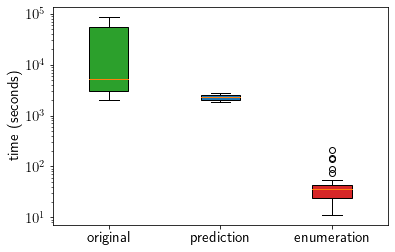

In [19]:
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = '15'

fig, ax = plt.subplots()
bp1 = ax.boxplot([xs[0]], positions=[1], widths=0.35, labels=[labels[0]],
                 patch_artist=True, boxprops=dict(facecolor="C2"))
bp2 = ax.boxplot([xs[1]], positions=[2], widths=0.35, labels=[labels[1]],
                 patch_artist=True, boxprops=dict(facecolor="C0"))
bp3 = ax.boxplot([xs[2]], positions=[3], widths=0.35, labels=[labels[2]],
                 patch_artist=True, boxprops=dict(facecolor="C3"))
ax.set_yscale('log')

plt.ylabel("time (seconds)")

# plt.savefig("figs/alphad3m_running_time.pdf", bbox_inches="tight")

Text(0, 0.5, 'speed up scale')

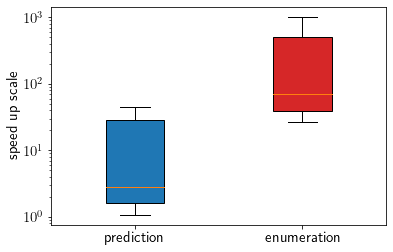

In [20]:
speed_up1 = [times[data_name]/(DDN_traintime[data_name]+np.random.uniform(1800, 2100, 1)[0]) for data_name in times]
speed_up2 = [times[data_name]/(DDN_traintime[data_name]+np.random.uniform(50, 60, 1)[0]) for data_name in times]
speed_ups = [speed_up1, speed_up2]

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = '15'

fig, ax = plt.subplots()
bp1 = ax.boxplot(speed_up1, positions=[1], widths=0.35, labels=[labels[1]],
                 patch_artist=True, boxprops=dict(facecolor="C0"))
bp1 = ax.boxplot(speed_up2, positions=[2], widths=0.35, labels=[labels[2]],
                 patch_artist=True, boxprops=dict(facecolor="C3"))
ax.set_yscale('log')

plt.ylabel("speed up scale")

# plt.savefig("figs/alphad3m_speed_up.pdf", bbox_inches="tight")


### top k

In [137]:
def ml4ml_actual(tests, preds, top_k=10):
    test_pred_pairs = []
    for t,p in zip(tests, preds):
        test_pred_pairs.append((t,p))
    test_pred_pairs_sorted = sorted(test_pred_pairs, key=lambda x:x[1], reverse=True)
    top_k_actuals = [i[0] for i in test_pred_pairs_sorted[:top_k]]
    return top_k_actuals


# test_pred_pairs = []
# for t,p in zip(target_test_pred_time_05["classification_batch6/airlines"][1], target_test_pred_time_05["classification_batch6/airlines"][2]):
#     test_pred_pairs.append((t,p))

# test_pred_pairs_sorted = sorted(test_pred_pairs, key=lambda x:x[1], reverse=True)
# test_pred_pairs_sorted

def scores_under_time_limit(data_pipes, time_limit=1800):
    scores = []
    onehots = []
    earliest_time = data_pipes['earliest_time']
    for created_time in data_pipes:
        if created_time not in ['earliest_time', 'latest_time']:
            if created_time < (earliest_time[0]+time_limit):
                scores.append(data_pipes[created_time][1])
                onehots.append(data_pipes[created_time][0])
    return scores, onehots


In [26]:
suffix = "_DDN+OneHot_0.1"
today = "_03102022"
target_test_pred_time = pickle.load(open("alphad3m_log/DDN+OneHot_target_test_pred_time"+today, "rb"))
target_test_pred_time_010 = {key.replace(suffix, ""):target_test_pred_time[key] for key in target_test_pred_time if '0.1' in key and '0.15' not in key}
print(len(target_test_pred_time_010.keys()))


39


In [47]:
time_limit = 3600*1

top_k_diffs = defaultdict(list)
for test_time in [0, 3600, 3600*2, 3600*4, 3600*12]:
    for top_k in range(1,21,1):
    # for top_k in [30]:
        results = []
        best_diffs = []

        for data_name in time_pipe:
            if target_test_pred_time_010[data_name] != 'N.A.':
                data_pipes = time_pipe[data_name]
                e_t = time_pipe[data_name]['earliest_time'][0]
                l_t = time_pipe[data_name]['latest_time'][0]
                if (l_t - e_t) > test_time:
                    scores_under, _ = scores_under_time_limit(time_pipe[data_name], time_limit=time_limit)

                    tests = target_test_pred_time_010[data_name][0]
                    preds = target_test_pred_time_010[data_name][1]
            #         test_max = np.max(tests)
                    test_max = np.max(scores_under)
                    top_actuals = ml4ml_actual(tests, preds, top_k=top_k)
            #         best_diff = (np.max(top_actuals)-np.max(scores_u30min))
                    best_diff = (np.max(top_actuals)-test_max)
                    best_diffs.append(best_diff)
                    results.append([data_name, top_k, np.max(top_actuals), test_max, best_diff])
            #         print(data_name, top_k, np.max(top_actuals), np.max(scores_u30min), (np.max(top_actuals)-np.max(scores_u30min)))
        top_k_diffs[test_time].append(np.mean(best_diffs))


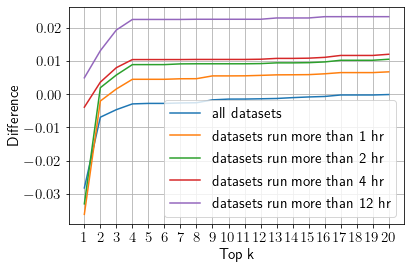

In [48]:
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = '15'

for test_time in top_k_diffs:
    y = top_k_diffs[test_time]
    x = [i+1 for i in range(len(y))]
    if test_time == 0:
        plt.plot(x, y, label='all datasets')
    else:
        plt.plot(x, y, label='datasets run more than '+str(int(test_time/3600))+' hr')

plt.xticks(range(1,21))
plt.ylabel('Difference')
plt.xlabel('Top k')
# plt.title('Different runtimes: The best score of predicted pipelines evaluted on datasets minus the best score of actual runnings')
plt.legend()
plt.grid()

# plt.savefig('figs/best_diff_1h.pdf', bbox_inches="tight")
plt.show()


# single dataset speed up

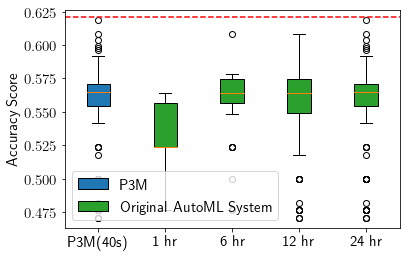

In [69]:
data_name = 'airlines'

time_limits = [3600*1, 3600*6, 3600*12, 3600*24]
scores_airlines_test1, _ = scores_under_time_limit(time_pipe[data_name], time_limit=time_limits[0])
scores_airlines_test2, _ = scores_under_time_limit(time_pipe[data_name], time_limit=time_limits[1])
scores_airlines_test3, _ = scores_under_time_limit(time_pipe[data_name], time_limit=time_limits[2])
scores_airlines_test4, _ = scores_under_time_limit(time_pipe[data_name], time_limit=time_limits[3])
scores_airlines_pred = target_test_pred_time_010[data_name][0]

thres = 0.2
scores_airlines_pred = [i for i in scores_airlines_pred if i > thres]
scores_airlines_test2 = [i for i in scores_airlines_test2 if i > thres]
scores_airlines_test3 = [i for i in scores_airlines_test3 if i > thres]
scores_airlines_test4 = [i for i in scores_airlines_test4 if i > thres]
tests = [scores_airlines_test1, scores_airlines_test2, scores_airlines_test3, 
         scores_airlines_test4]
evals_labels=['1 hr', '6 hr', '12 hr', '24 hr']

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = '15'

fig, ax = plt.subplots()
bp1 = ax.boxplot(scores_airlines_pred, positions=[1], widths=0.35, labels=['P3M(40s)'],
                 patch_artist=True, boxprops=dict(facecolor="C0"))
bp2 = ax.boxplot(tests, positions=[2,3,4,5],widths=0.35, labels=evals_labels,
                 patch_artist=True, boxprops=dict(facecolor="C2"))
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['P3M', 'Original AutoML System'], loc='lower left')

plt.ylabel('Accuracy Score')
plt.axhline(y=max(scores_airlines_pred)+0.0025, color='r', linestyle='--')
# plt.savefig('figs/boxplot_'+data_name+'_alphad3m.pdf', bbox_inches="tight")

plt.show()


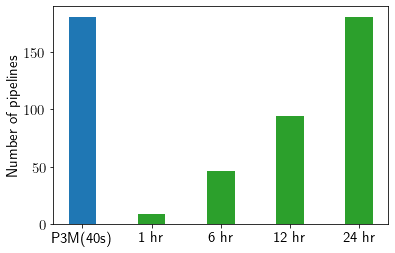

In [51]:
# libraries
import numpy as np
import matplotlib.pyplot as plt

_, onehot1 = scores_under_time_limit(time_pipe[data_name], time_limit=time_limits[0])
_, onehot2 = scores_under_time_limit(time_pipe[data_name], time_limit=time_limits[1])
_, onehot3 = scores_under_time_limit(time_pipe[data_name], time_limit=time_limits[2])
_, onehot4 = scores_under_time_limit(time_pipe[data_name], time_limit=time_limits[3])

pipe = [len(onehot4), len(onehot1), len(onehot2), len(onehot3), len(onehot4)]
bars = ('P3M(40s)', '1 hr', '6 hr', '12 hr', '24 hr')
x_pos = np.arange(len(bars))

plt.bar(x_pos+0.0, pipe, color=['C0','C2','C2','C2', 'C2'], width=0.4)
plt.xticks(x_pos, bars)
plt.ylabel('Number of pipelines')

# plt.savefig('figs/pipelines_'+data_name+'_alphad3m.pdf', bbox_inches="tight")

# Show graph
plt.show()

0 adult


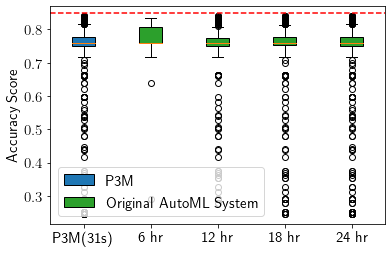

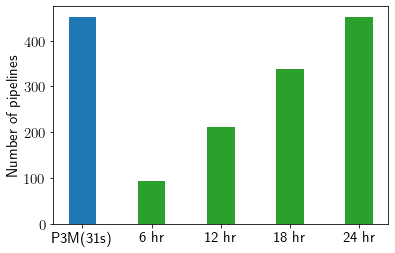

1 airlines


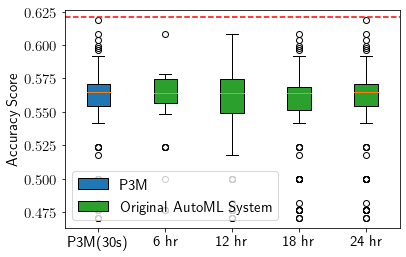

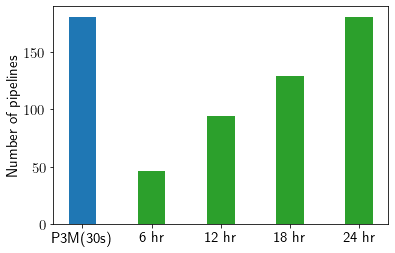

2 albert


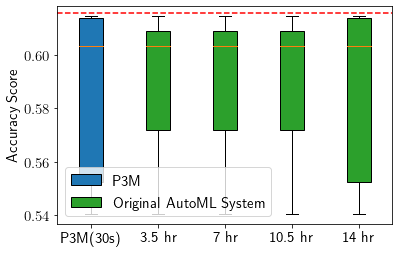

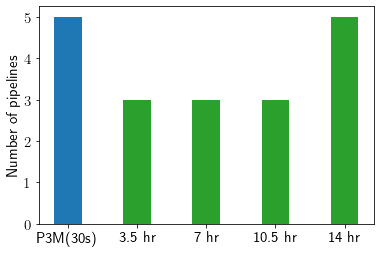

3 Amazon_employee_access


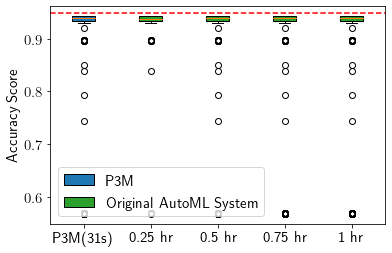

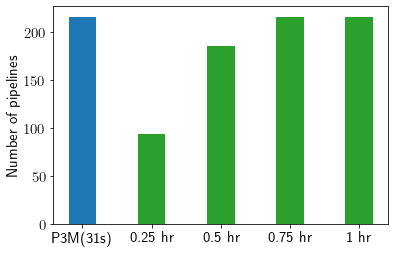

4 APSFailure


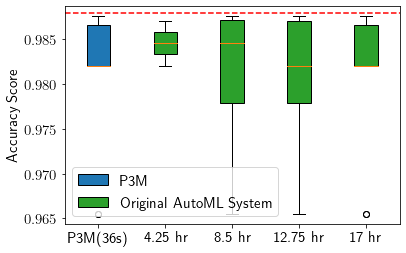

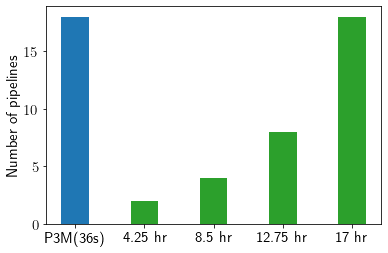

5 Australian


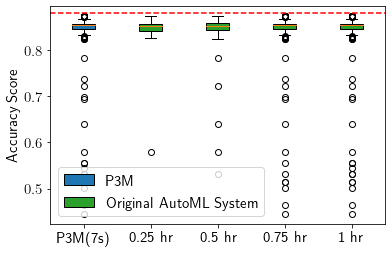

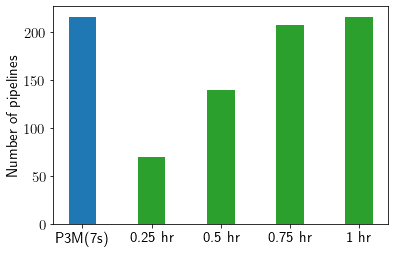

6 bank-marketing


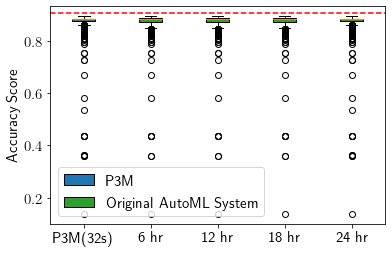

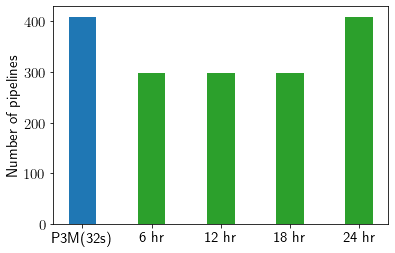

7 blood-transfusion-service-center


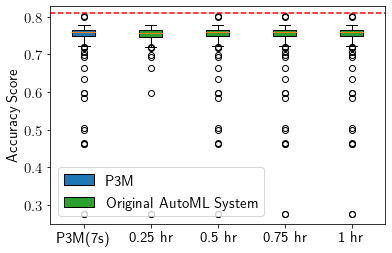

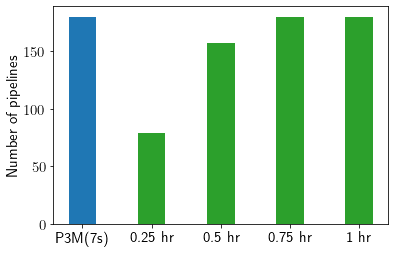

8 car


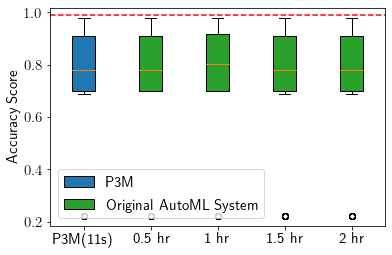

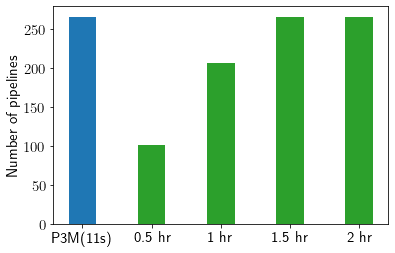

9 christine


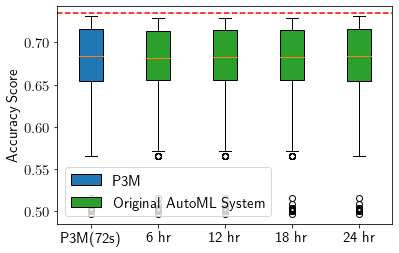

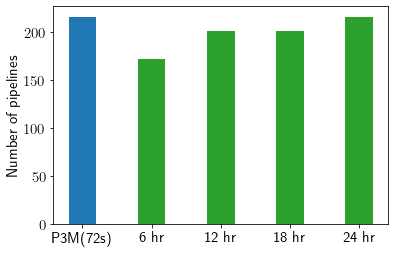

10 cnae-9


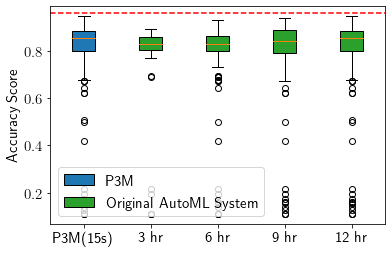

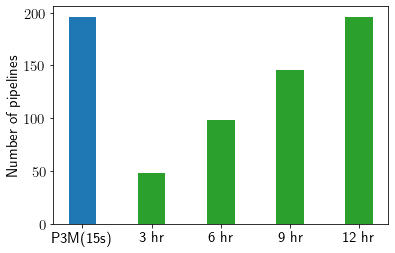

11 connect-4


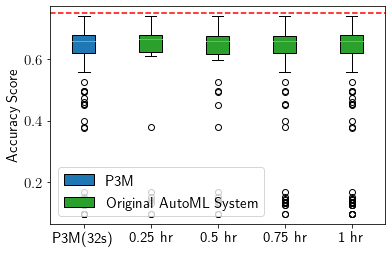

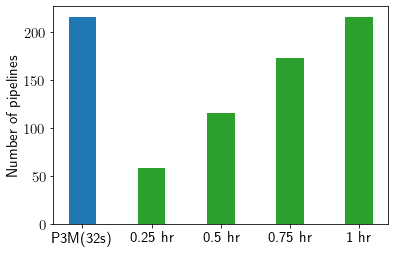

12 covertype


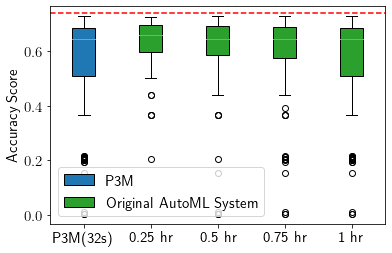

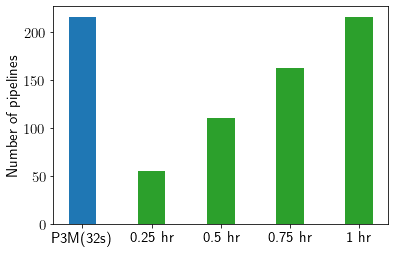

13 credit-g


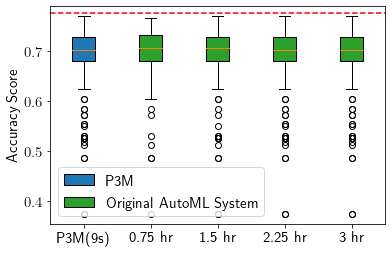

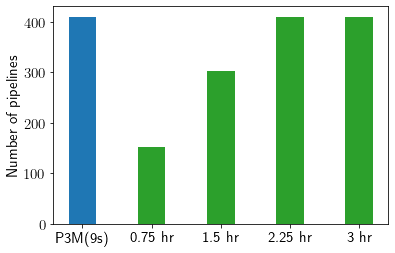

14 dilbert


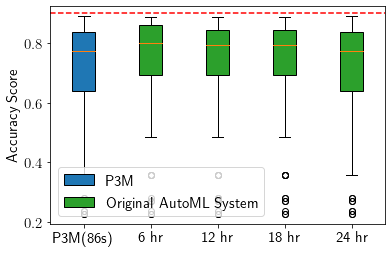

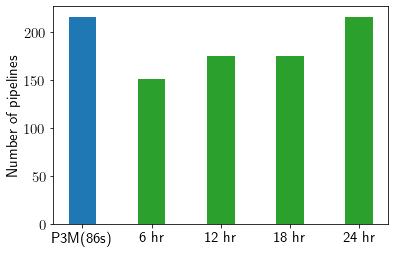

15 dionis


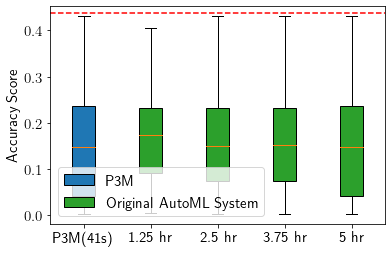

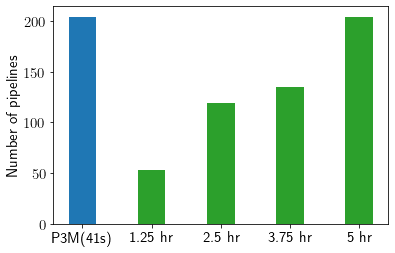

16 fabert


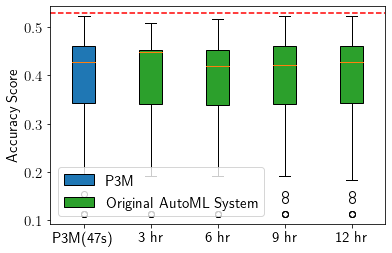

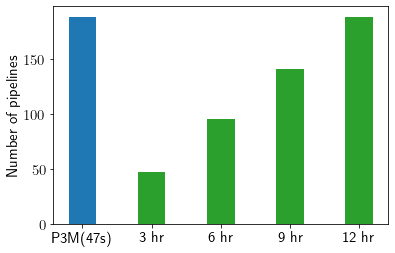

17 fashion_mnist


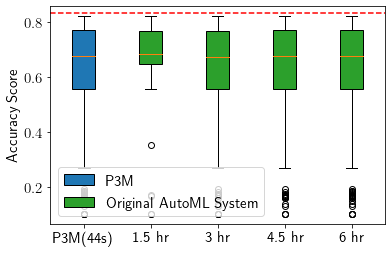

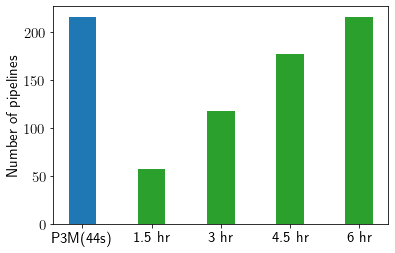

18 guillermo


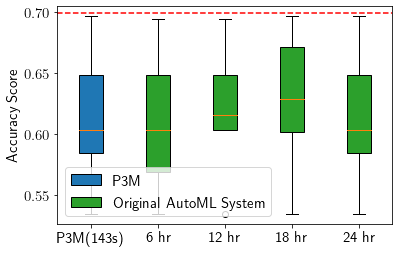

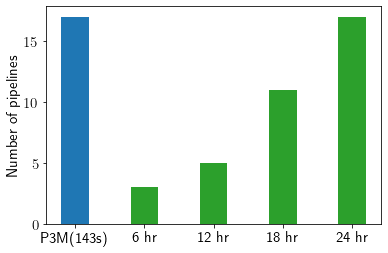

19 helena


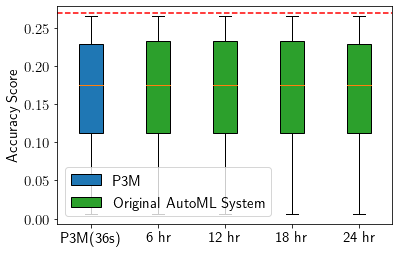

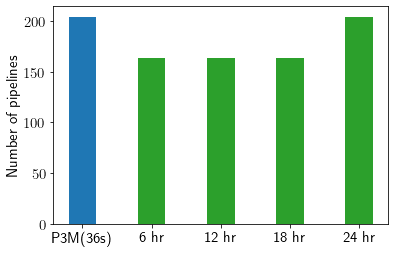

20 higgs


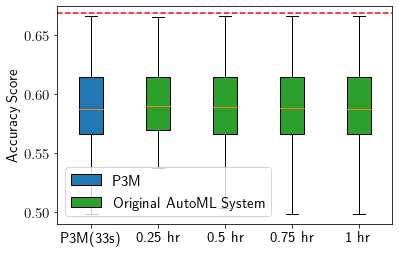

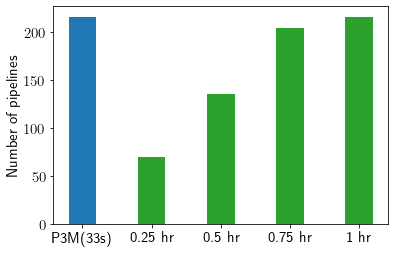

21 jannis


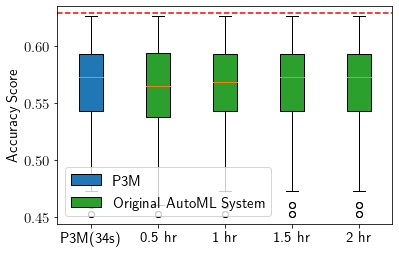

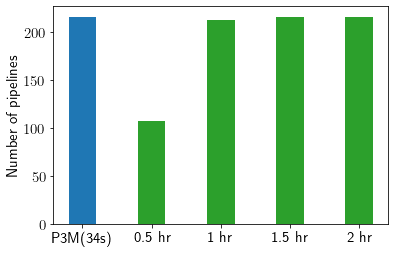

22 jasmine


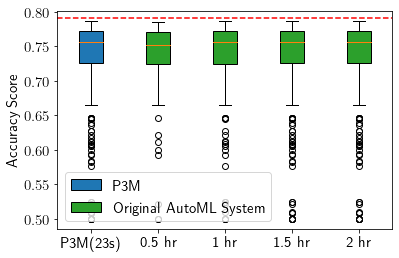

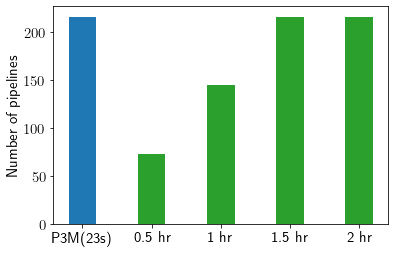

23 jungle_chess_2pcs_raw_endgame_complete


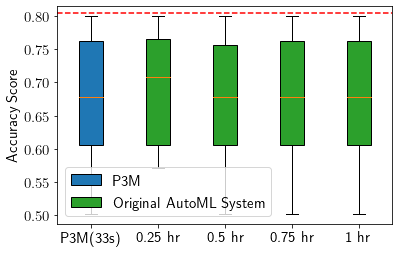

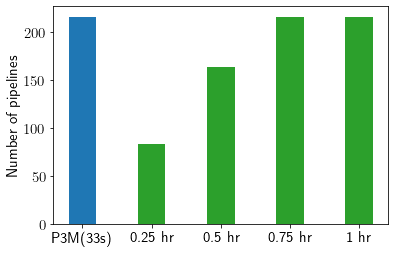

24 kc1


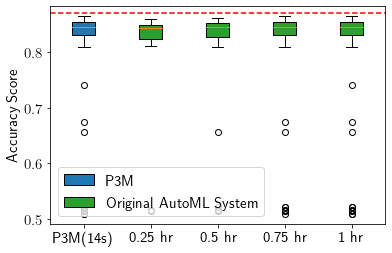

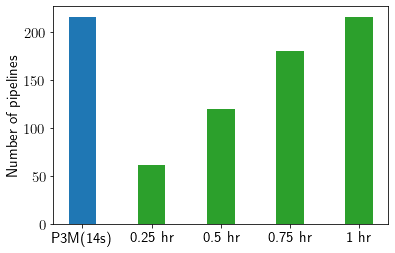

25 KDDCup09_appetency


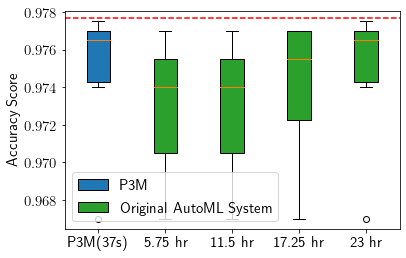

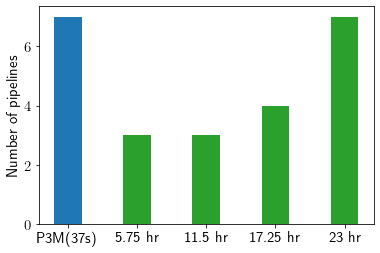

26 kr-vs-kp


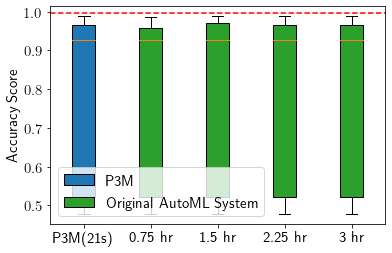

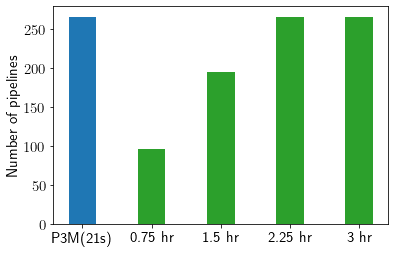

27 mfeat-factors


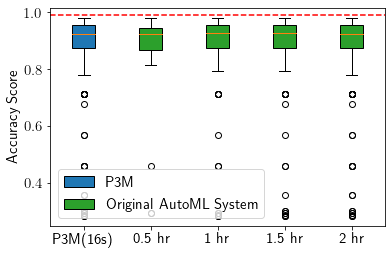

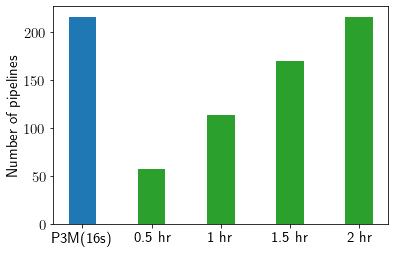

28 MiniBooNE


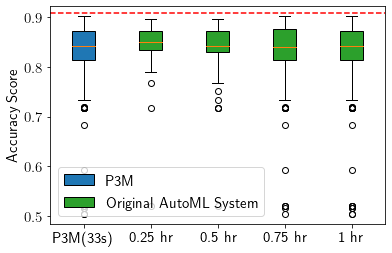

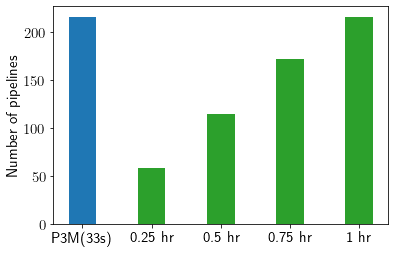

29 nomao


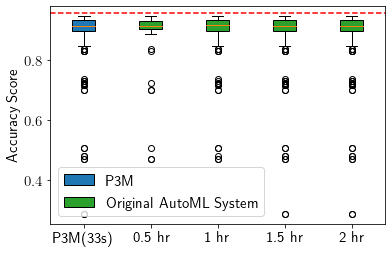

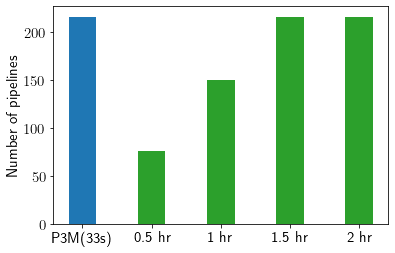

30 numerai28.6


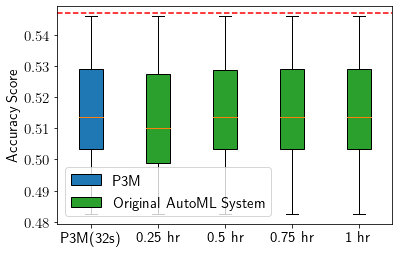

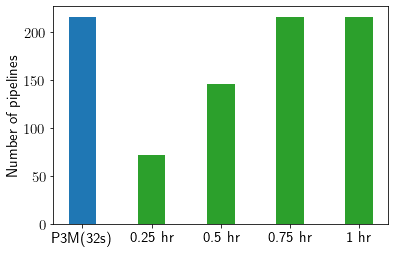

31 phoneme


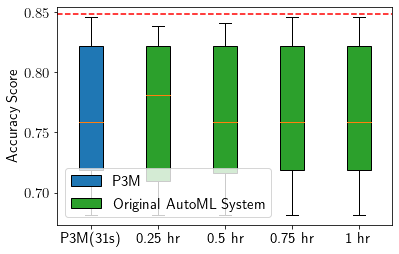

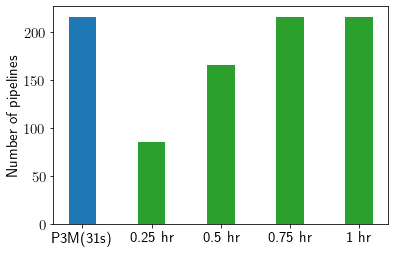

32 riccardo


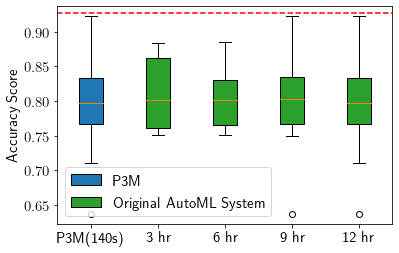

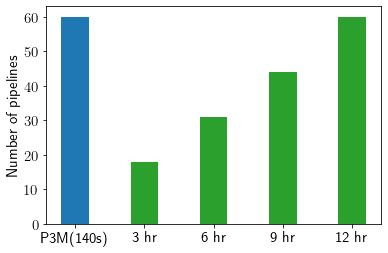

33 robert


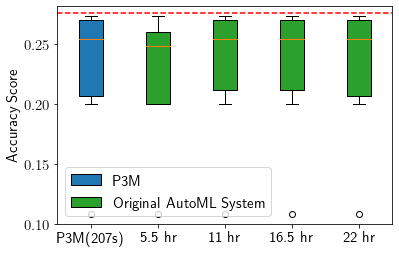

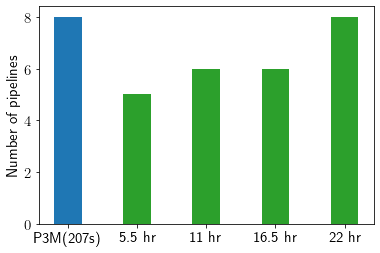

34 segment


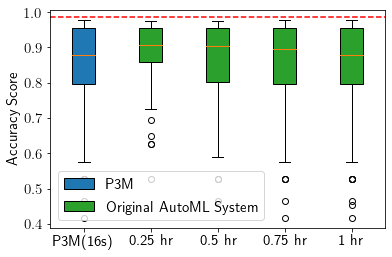

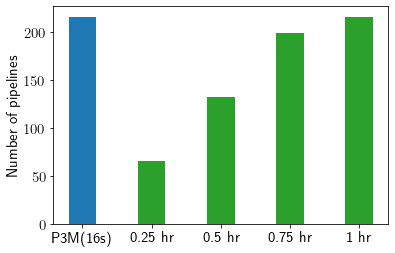

35 shuttle


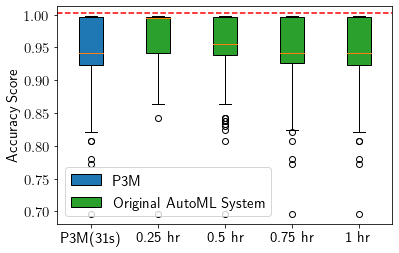

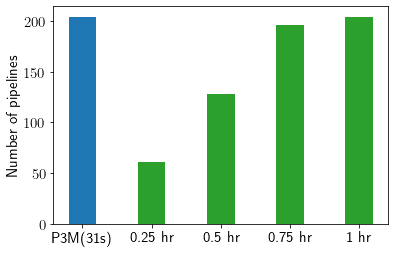

36 sylvine


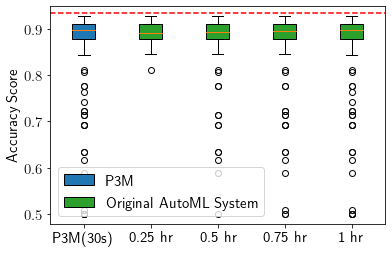

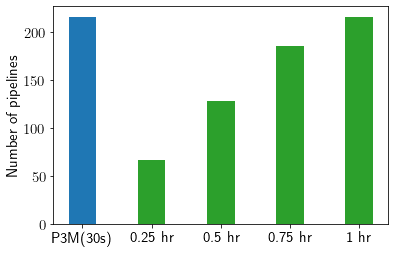

37 vehicle


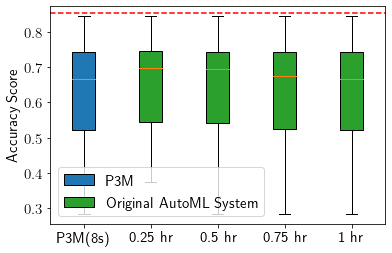

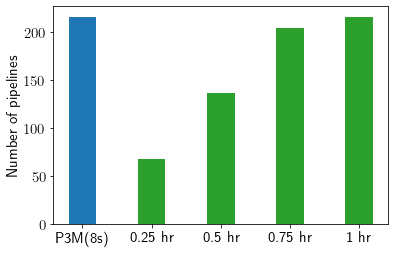

38 volkert


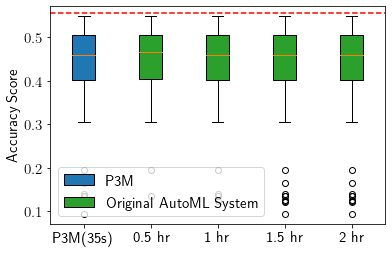

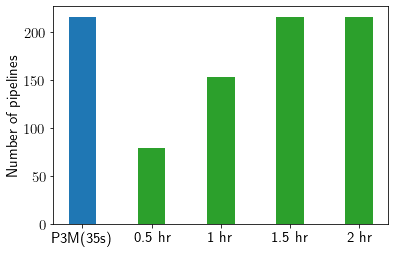

In [142]:
import matplotlib.pyplot as plt
import matplotlib

data_names = list(DDN.keys())
for i,data_name in enumerate(data_names):
    print(i, data_name)
    max_time = times[data_name]
    max_time = times[data_name]
    max_hours = np.ceil(max_time/3600)
    hours = [max_hours/4, max_hours/2, max_hours/4*3, max_hours]
    new_hours = []
    time_limits = []
    for hour in hours:
        if hour == round(hour):
            hour = round(hour)
        elif hour == round(hour,1):
            hour = round(hour,1)
        else:
            hour = round(hour,2)
        new_hours.append(hour)
        time_limits.append(3600*hour)
        
    scores1, _ = scores_under_time_limit(time_pipe[data_name], time_limit=time_limits[0])
    scores2, _ = scores_under_time_limit(time_pipe[data_name], time_limit=time_limits[1])
    scores3, _ = scores_under_time_limit(time_pipe[data_name], time_limit=time_limits[2])
    scores4, _ = scores_under_time_limit(time_pipe[data_name], time_limit=time_limits[3])
    scores_pred = \
    [time_pipe[data_name][key][1] for key in time_pipe[data_name] if key!="earliest_time" and key!="latest_time" and time_pipe[data_name][key]!=[]]
    time_pred = DDN_train[data_name]['training_time']

    tests = [scores1, scores2, scores3, scores4]
    evals_labels=[str(i)+" hr" for i in new_hours]


    matplotlib.rcParams['text.usetex'] = True
    matplotlib.rcParams['font.size'] = '15'
    fig, ax = plt.subplots()
    bp1 = ax.boxplot(scores_pred, positions=[1], widths=0.35, labels=["P3M("+str(round(time_pred))+"s)"],
                     patch_artist=True, boxprops=dict(facecolor="C0"))
    bp2 = ax.boxplot(tests, positions=[2,3,4,5],widths=0.35, labels=evals_labels,
                     patch_artist=True, boxprops=dict(facecolor="C2"))
    ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['P3M', 'Original AutoML System'], loc='lower left')

    plt.ylabel('Accuracy Score')
    plt.axhline(y=max(scores_pred)+(max(scores_pred)-min(scores_pred))*0.015, color='r', linestyle='--')
    plt.savefig('figs_0310/boxplot_'+data_name+'_alphad3m.pdf', bbox_inches="tight")

    plt.show()

    # libraries
    import numpy as np

    _, onehot1 = scores_under_time_limit(time_pipe[data_name], time_limit=time_limits[0])
    _, onehot2 = scores_under_time_limit(time_pipe[data_name], time_limit=time_limits[1])
    _, onehot3 = scores_under_time_limit(time_pipe[data_name], time_limit=time_limits[2])
    _, onehot4 = scores_under_time_limit(time_pipe[data_name], time_limit=time_limits[3])

    pipe = [len(onehot4), len(onehot1), len(onehot2), len(onehot3), len(onehot4)]
    bars = ["P3M("+str(round(time_pred))+"s)"]+evals_labels
    x_pos = np.arange(len(bars))

    plt.bar(x_pos+0.0, pipe, color=['C0','C2','C2','C2', 'C2'], width=0.4)
    plt.xticks(x_pos, bars)
    plt.ylabel('Number of pipelines')

    plt.savefig('figs_0310/pipelines_'+data_name+'_alphad3m.pdf', bbox_inches="tight")

    # Show graph
    plt.show()
    
    
    

In [140]:
times['helena']

85986

In [130]:
created_time

27989

In [117]:
for key in time_pipe[data_name]:
    if key!="earliest_time" and key!="latest_time":
        print(time_pipe[data_name][key])
        print(key, time_pipe[data_name][key][1])

[[1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0.224]
7980 0.224
[[1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0.242]
3637 0.242
[[1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0.2375]
5813 0.2375
[[1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0.08499999999999999]
86197 0.08499999999999999
[[1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0.175]
5767 0.175
[[1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], 0.2365]
5848 0.2365
[[1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0.14]
2085 0.14
[[1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0

IndexError: list index out of range

In [114]:
time_pipe[data_name].keys()

dict_keys([7980, 'earliest_time', 'latest_time', 3637, 5813, 86197, 5767, 5848, 2085, 6139, 85851, 7950, 3602, 85974, 5729, 6968, 3628, 85717, 7828, 6177, 7783, 6152, 6954, 3345, 86147, 7603, 5934, 7709, 1977, 7018, 6260, 2415, 1122, 2392, 1369, 3769, 7089, 3468, 86021, 2427, 7001, 7675, 85802, 271, 4878, 4257, 4672, 4866, 3697, 3564, 3489, 6164, 86185, 6072, 7757, 7637, 1147, 3732, 2511, 6897, 3590, 7905, 86084, 2002, 4769, 3542, 85936, 85743, 1160, 6299, 3819, 85781, 6097, 2018, 7200, 2160, 7144, 3371, 6123, 2097, 5864, 86235, 3358, 7938, 6367, 1989, 3794, 5780, 5989, 7847, 6217, 3505, 86122, 86097, 5879, 2060, 2174, 2072, 7919, 1135, 6238, 7796, 3720, 86009, 85949, 85731, 85892, 6354, 2367, 3517, 6463, 7066, 6942, 86222, 2405, 5755, 3757, 85908, 3650, 4245, 1356, 7687, 1110, 1927, 6273, 1955, 3530, 3681, 6448, 86072, 7697, 86210, 6286, 2461, 86034, 7178, 1942, 2499, 6110, 7770, 2939, 86059, 1394, 1407, 1821, 5323, 2135, 85706, 85880, 7887, 7033, 7732, 3665, 7649, 3782, 85924, 2043, 

In [90]:
max_time = times[data_name]
max_hours = np.ceil(max_time/3600)
hours = [max_hours/4, max_hours/2, max_hours/4*3, max_hours]
new_hours = []
for hour in hours:
    if hour == round(hour):
        hour = round(hour)
    elif hour == round(hour,1):
        hour = round(hour,1)
    else:
        hour = round(hour,2)
    new_hours.append(str(hour))


print(max_time, max_hours, new_hours)


85815 24.0 ['6', '12', '18', '24']


In [93]:
times

{'blood-transfusion-service-center': 2035,
 'cnae-9': 43177,
 'dilbert': 86304,
 'dionis': 17750,
 'fabert': 43028,
 'helena': 85986,
 'numerai28.6': 2685,
 'riccardo': 42206,
 'robert': 76580,
 'volkert': 4925,
 'higgs': 2896,
 'vehicle': 2872,
 'jannis': 3645,
 'MiniBooNE': 3399,
 'Australian': 2821,
 'credit-g': 7371,
 'mfeat-factors': 6722,
 'kc1': 3255,
 'jasmine': 5332,
 'KDDCup09_appetency': 79917,
 'guillermo': 86202,
 'APSFailure': 58825,
 'christine': 86289,
 'connect-4': 3387,
 'covertype': 3581,
 'kr-vs-kp': 7592,
 'nomao': 5170,
 'albert': 50253,
 'Amazon_employee_access': 2132,
 'adult': 85815,
 'airlines': 85524,
 'bank-marketing': 86388,
 'car': 4789,
 'jungle_chess_2pcs_raw_endgame_complete': 2425,
 'phoneme': 2404,
 'segment': 2955,
 'shuttle': 2817,
 'sylvine': 3144,
 'fashion_mnist': 19287}